# Facial Emotion Recognition

* Fer2013 dataset is a common dataset used for facial expression recognition. The dataset contains 35,887 grayscale facial images containing 7 different emotions (anger, disgust, fear, happiness, neutral, sad, and surprise).

* VGG19 is a deep learning model known as the Convolutional Neural Network (CNN) architecture. The VGG19 model has 19 layers and consists of 16 layers of convolutional layers and 3 layers of fully connected layers. Convolutional layers extract features from the input image using filters.

* Transfer learning can be performed using the pre-trained weights of the VGG19 model. Transfer learning is the use of the weights of a pre-trained model to help solve a problem in a new dataset.

* For the VGG19 model, pre-trained weights are often used to classify images in the ImageNet dataset. Therefore, the last layer of the VGG19 model is retrained to make it suitable for facial expressions in the fer2013 dataset.

* The last layer of the VGG19 model consists of fully connected layers. These layers are used to classify facial expressions in the dataset. Since there are 7 different emotion classes in the Fer2013 dataset, the last layer of the VGG19 model is retrained to have a 7-output classifier.

* Retraining of the VGG19 model is performed with multiple epochs to achieve higher accuracy rates. An epoch is a complete scan of the training data by the model once.

* During training, performance metrics such as model accuracy and loss are tracked. At the end of the training, the accuracy of the model is evaluated by its performance on the test data.
* The VGG19 model gives very good results for the classification of facial expressions in the Fer2013 dataset. However, there may be imbalance between classes in the dataset. Therefore, taking into account the imbalance of training data between classes can help improve the performance of the model.
 
* To further improve the performance of the model, data preprocessing techniques can be used. For example, the sizes of faces in the dataset can be standardized and filtering techniques can be applied to reduce noise.
 
* The VGG19 model is a widely used model in the field of facial expression recognition in the Fer2013 dataset. However, there are other models that perform better on different datasets. Therefore, different models may be preferred depending on the characteristics of the data set and the problem area.
 
* Finally, different metrics can be used to evaluate the performance of the model. For example, metrics such as accuracy, sensitivity, specificity, F1 score, and ROC curve can help evaluate model performance from different perspectives.

In [7]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Submission.csv
/kaggle/input/fer2013/fer2013/README
/kaggle/input/fer2013/fer2013/fer2013.bib
/kaggle/input/fer2013/fer2013/fer2013.csv


In [11]:
!pip install tensorflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Library

In [18]:
import math
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [19]:
import pandas as pd

df = pd.read_csv('/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [20]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [21]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [22]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [23]:
import math
math.sqrt(len(df.pixels[0].split(' ')))

48.0

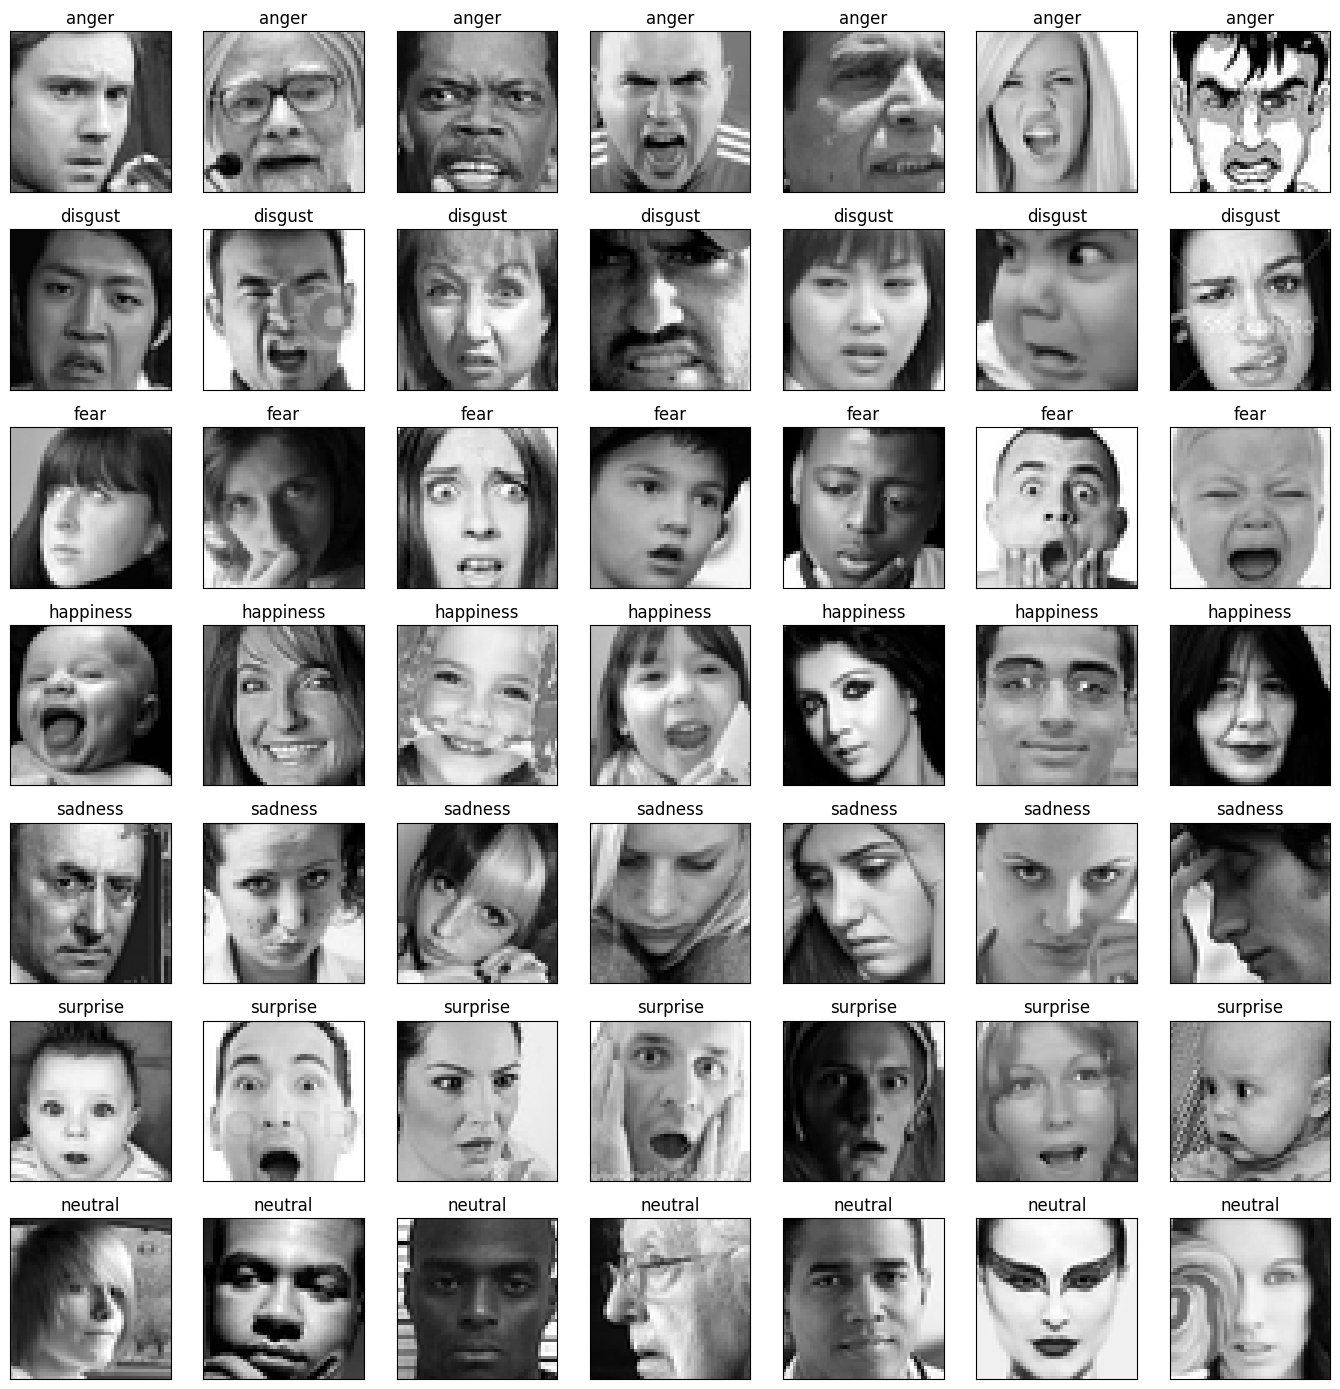

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

### Now I will make the data compatible for neural networks.

In [27]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [28]:
img_array.shape

(35887, 48, 48)

In [29]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


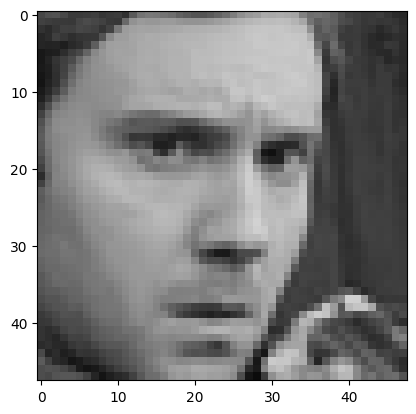

In [31]:
plt.imshow(img_features[0].astype(np.uint8));

In [36]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical  # Correct import for to_categorical

# Assuming df is your DataFrame and 'emotion' is the column of labels
le = LabelEncoder()

# Encode emotion labels as integers
img_labels = le.fit_transform(df['emotion'])

# Convert integer-encoded labels to one-hot encoding using to_categorical from keras
img_labels = to_categorical(img_labels)

# Check the shape of the one-hot encoded labels
print(img_labels.shape)


(35887, 7)


In [37]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Splitting the data into training and validation set.

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [39]:
del df
del img_features
del img_labels

In [40]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [41]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [42]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [43]:
# for layer in vgg.layers:
    # layer.trainable = False

In [44]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [47]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 20,027,975 (76.40 MB)

 Non-trainable params: 0 (0.00 B)

None


### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [48]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [49]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [50]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [54]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True)
train_datagen.fit(X_train)

# Batch size and epochs
batch_size = 32
epochs = 25

# Optimizer configuration
optims = [optimizers.Adam(learning_rate=0.0001, 
                          beta_1=0.9, beta_2=0.999)]

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optims[0],
              metrics=['accuracy'])

# Fit the model (removed `use_multiprocessing` argument)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729069157.885445     281 service.cc:145] XLA service 0x78875401bbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729069157.885517     281 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   5/1009 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.2147 - loss: 2.0654

I0000 00:00:1729069163.104498     281 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - accuracy: 0.3115 - loss: 1.6919 - val_accuracy: 0.5235 - val_loss: 1.2401 - learning_rate: 1.0000e-04
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.5938 - loss: 0.9977

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.5938 - loss: 0.9977 - val_accuracy: 0.5160 - val_loss: 1.2575 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.5154 - loss: 1.2690 - val_accuracy: 0.5600 - val_loss: 1.1788 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5312 - loss: 1.2913 - val_accuracy: 0.5612 - val_loss: 1.1666 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.5513 - loss: 1.1855 - val_accuracy: 0.5617 - val_loss: 1.1945 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.8125 - loss: 0.7559 - val_accuracy: 0.5564 - val_loss: 1.2015 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.5719 - loss: 1.1313 - val_accuracy: 0.6230 - val_loss: 1.0387 - learning_rate: 1.0000e-04
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/st

In [55]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

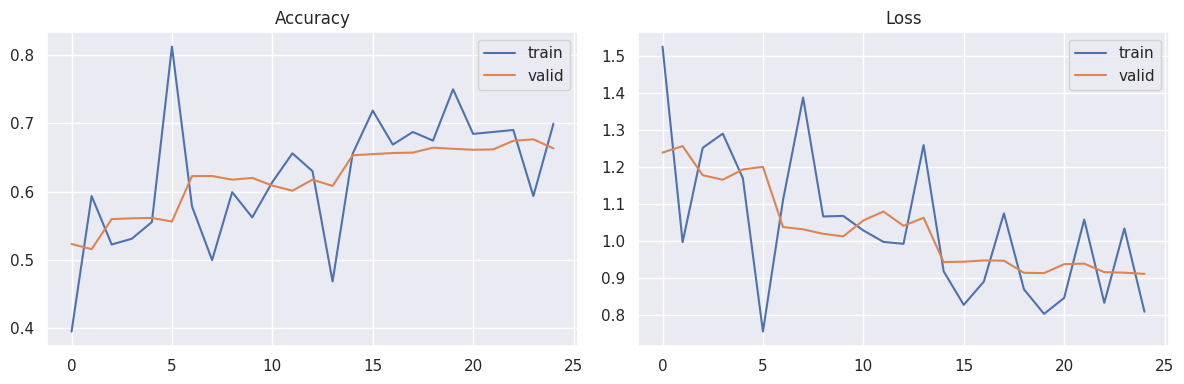

In [57]:
import warnings 
warnings.filterwarnings('ignore')
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()


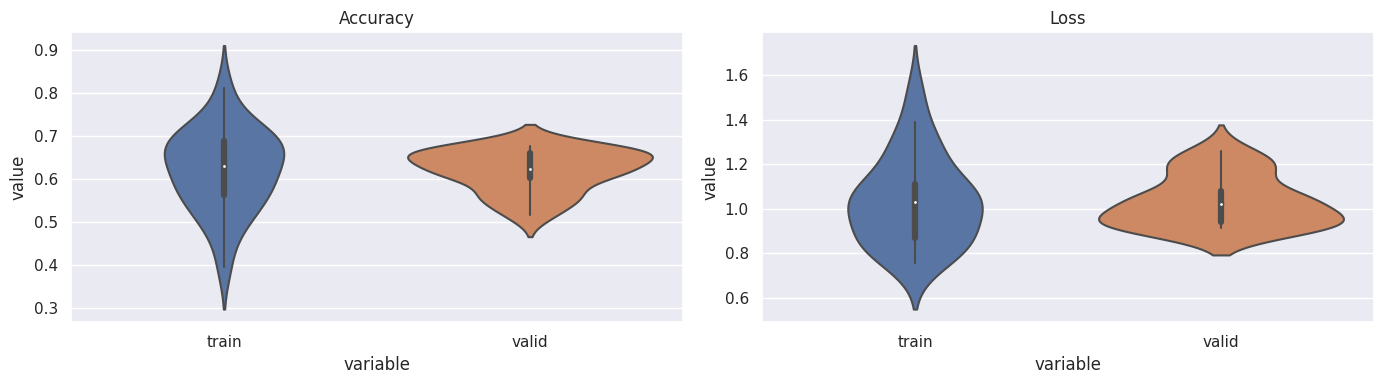

In [60]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = plt.figure(0, (14, 4))
ax = plt.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
plt.title('Loss')
plt.tight_layout()

plt.savefig('performance_dist.png')
plt.show()

In [62]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
total wrong validation predictions: 1160


              precision    recall  f1-score   support

           0       0.64      0.63      0.63       495
           1       0.94      0.27      0.42        55
           2       0.56      0.40      0.47       512
           3       0.86      0.90      0.88       899
           4       0.59      0.50      0.54       608
           5       0.78      0.73      0.76       400
           6       0.55      0.78      0.64       620

    accuracy                           0.68      3589
   macro avg       0.70      0.60      0.62      3589
weighted avg       0.68      0.68      0.67      3589



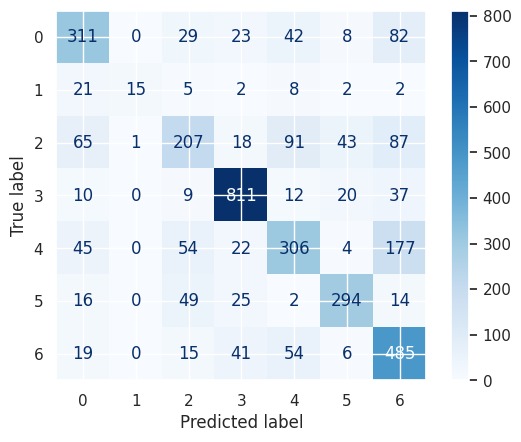

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Generate predictions for the validation set
yhat_valid = np.argmax(model.predict(X_valid), axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid)

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("confusion_matrix_dcnn.png")


In [66]:
# Print classification report
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63       495
           1       0.94      0.27      0.42        55
           2       0.56      0.40      0.47       512
           3       0.86      0.90      0.88       899
           4       0.59      0.50      0.54       608
           5       0.78      0.73      0.76       400
           6       0.55      0.78      0.64       620

    accuracy                           0.68      3589
   macro avg       0.70      0.60      0.62      3589
weighted avg       0.68      0.68      0.67      3589



### The confusion matrix clearly shows that our model is doing good job on the class happy but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [67]:
# Print the number of incorrect predictions
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')

total wrong validation predictions: 1160




In [68]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


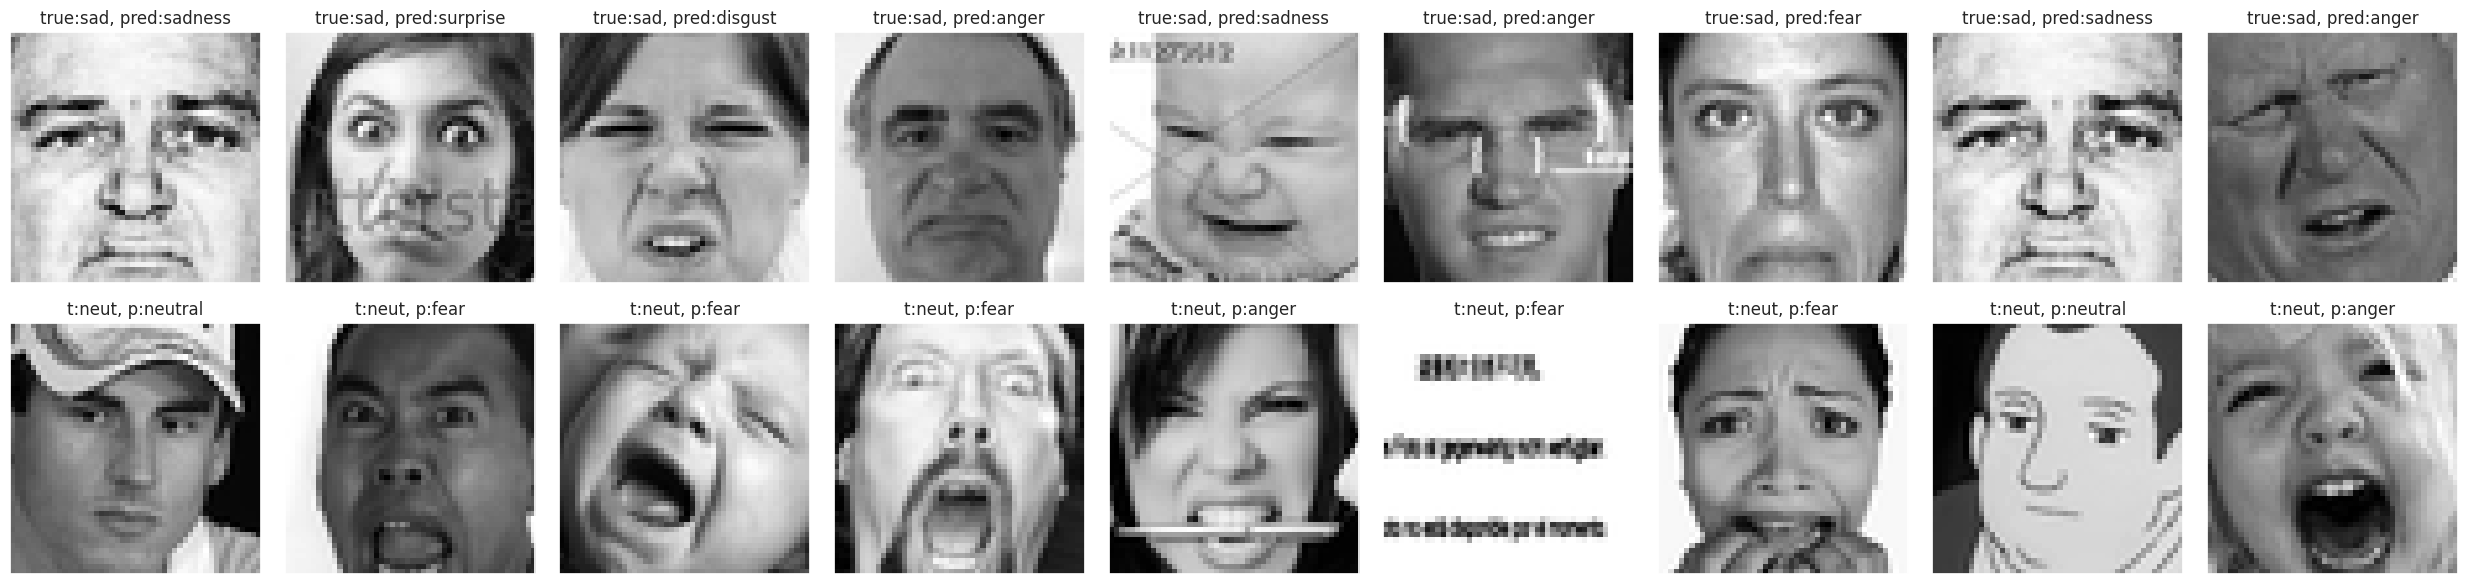

In [76]:
np.random.seed(42)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = plt.figure(1, (25, 6))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
        
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

        plt.tight_layout()